# Vedant Gaurang Shah; 200101115

## Topic: Analyze word2vec embedding by demonstrating clustering on a subtitle file of a movie of your choice

### Understanding Word2Vec
Word2Vec is a powerful technique for generating word embeddings, which are numerical representations of words that capture their semantic meaning. These embeddings allow us to understand the relationships among words; for example, similar words tend to have similar vector representations.

![Overview of Word2vec](./overview_word2vec.drawio.png)

The vectors used to represent the words are called neural word embeddings, and representations are strange. One thing describes another, even though those two things are radically different. Word2vec "vectorizes" about words, and by doing so it makes natural language computer-readable - we can start to perform powerful mathematical operations on words to detect their similarities.

Word2Vec is one of the most popular technique for **word embeddings** (??, what are those?) using shallow neural networks.

**Word Embedding** is one of the most popular representation of document vobulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc (as told before).

So loosely speaking, **word embeddings** are vector representations of a particular word.
Now the question, how are textual words converted to some mathematical, numerical vectors? How do we generate them?? And how do they capture the context??

There are 2 methods for word2vec, such as **CBOW** and **Skip-Gram**. Given a set of sentences (also called corpus), the model loops on the words of each sentences and either try to use the current word w in order to predict its neighbors (i.e, its context), this approach is called "Skip-Gram", or its employs each of these contexts to predict the current word _w_, in that case, the approach is called "Continuous Bag of Words" (CBOW). To limit the number of words in each context and tune the performance of the model, a parameter called "window size" is used.

Simply stating:
* CBOW (Continuous Bag of Words): Predicts a target word based on the surrounding context.
* Skip-gram: Predicts surrounding context words based on a target word.

More about CBOW vs Skip-gram as an overview can be read from [page](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

![](./cbow_vs_skip_gram.webp)

### Code

As of this tutorial, we are going to use Skip-gram (because it produces more accurate results on large datasets!) which in contrast to CBOW considers center word as input as depicted in the figure above and predicts the context words.

In [142]:
# importing required libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from wordcloud import WordCloud
nltk.download('punkt')  # Download for sentence tokenization
nltk.download('stopwords')  # Download stop words

[nltk_data] Downloading package punkt to /home/waydant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/waydant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Loads subtitles from an SRT file, extracts dialogue, and performs preprocessing.
def load_and_preprocess_subtitles(file_path):
    stop_words = set(stopwords.words('english'))
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    dialogue_lines = []
    current_dialogue = []
    for line in lines:
        line = line.strip()
        if line.isdigit():      # Check if the line is a subtitle index
            if current_dialogue:
                dialogue_lines.append(current_dialogue)
                current_dialogue = []
        elif line:
            current_dialogue.append(line)
    if current_dialogue:
        dialogue_lines.append(current_dialogue)
    # Preprocessing
    processed_text = []                                     # A list of preprocessed sentences (each sentence is a list of tokens).
    for dialogue in dialogue_lines:
        sentences = nltk.sent_tokenize(' '.join(dialogue))  # Tokenize into sentences
        tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
        # Remove stop words and convert to lowercase
        processed_sentences = []
        for sentence in tokenized_sentences:
            words = [word.lower() for word in sentence if word.isalpha() and word not in stop_words]
            processed_sentences.append(words)
        processed_text.extend(processed_sentences)
    return processed_text

In [111]:
# clustering the model using k_means
def clustering(model, num_clusters = 10, seed = 0):
  word_vectors = model.wv.vectors
  # num_clusters = 10  # Adjust as needed
  kmeans = KMeans(n_clusters=num_clusters, random_state = seed, max_iter=5000)
  kmeans.fit(word_vectors)
  cluster_labels = kmeans.labels_
  return cluster_labels

In [124]:
# printing the top 5 words from each cluster
def analyzing_clusters(num_clusters, cluster_labels, model):
  clusters = []
  for cluster_id in range(num_clusters):
      print(f"Cluster {cluster_id}:")
      words_in_cluster = []
      for i, label in enumerate(cluster_labels):
          if label == cluster_id:
              words_in_cluster.append(model.wv.index_to_key[i])
      clusters.append(words_in_cluster)
      print(words_in_cluster[:15])

In [151]:
# return the top 15 words of each cluster
def get_top_words_per_cluster(num_clusters, cluster_labels, model):
  clusters = []
  for cluster_id in range(num_clusters):
      words_in_cluster = []
      for i, label in enumerate(cluster_labels):
          if label == cluster_id:
              words_in_cluster.append(model.wv.index_to_key[i])
      clusters.append(words_in_cluster[:15])
  return clusters

In [127]:
subtitle_file = './Titanic.1997.720p.BluRay.X264-AMIABLE.srt'
preprocessed_subtitles = load_and_preprocess_subtitles(subtitle_file)

In [88]:
print(preprocessed_subtitles[:5])

[['meters'], ['you', 'see'], ['okay', 'take', 'bow', 'rail'], ['mir', 'going', 'bow'], ['stay', 'us']]


__preprocessed_subtitles__ is a list of subtitles, i.e. each element of the list is a subtitle on a given timestamp.
Each subtitle is further tokenized into tokens (words), hence __preprocessed_subtitles__ is a list of lists of token 

In [66]:
# Analyzing the preprocessed_subtitles
print(f'Number of sentences: {len(preprocessed_subtitles)}')
total_words = 0
for sentence in preprocessed_subtitles:
    total_words += len(sentence)
print(f'Number of words: {total_words}')
# Unique words
unique_words = set()
for sentence in preprocessed_subtitles:
    unique_words.update(sentence)
print(f'Number of unique words: {len(unique_words)}')

Number of sentences: 2608
Number of words: 7214
Number of unique words: 1861


#### It's important to note that this is considered a relatively small dataset for many NLP tasks.

Now we try to create and train our word 2 vector embeddings, using the [word2vec function](https://radimrehurek.com/gensim/models/word2vec.html) from the gensim library.


```
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=100, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model
```

We notice that model training takes some arguments namely:\
`sentences`: Our input (list of lists of token)\
`vector_size`: Dimensionality of the word vectors\
`window`: Maximum distance between the current and predicted word within a sentence\
`min_count`: Ignores all words with total frequency lower than this\
`workers`: Use these many worker threads to train the model (=faster training with multicore machines)\

arguments namely `sentences`, `min_count`, and `workers` are normally fixed. We consider `vector_size` and `window` as our 2 parameters of our model of which `window = 5` seems to be a good choice, as all the sentences of our corpus are a subtitle at a given timestamp, which are not long than around 7-8 words, hence 5 covers almost avg of it.\
The only major parameter left to tune is `vector_size`. If the `vector_size` is very low, then many words will be unnecessary be close due to low degrees of freedom for all words, and if the `vector_size` is very high, then all words will have their own axis (dimension), hence increasing the distance tremendously.\

This demands us to find an optimal value of `vector_size`

To do so, I try different values of `vector_size` (100, 80, 70, 50, 20), see their results for some fixed words (`titanic`, `love`, `iceberg`, `rose`, `boat`, `deck`, `please`) which are quiet famous and frequently spoken among the film.

We chose that value of `vector_size`, which gives a good similar words for these set of fixed, chosen words.

In [98]:
# Case V_100: vector size = 100
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=100, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

print(f'Word similar to titanic: {model.wv.most_similar("titanic")}')
print(f'Word similar to love: {model.wv.most_similar("love")}')
print(f'Word similar to iceberg: {model.wv.most_similar("iceberg")}')
print(f'Word similar to rose: {model.wv.most_similar("rose")}')
print(f'Word similar to boat: {model.wv.most_similar("boat")}')
print(f'Word similar to deck: {model.wv.most_similar("deck")}')
print(f'Word similar to jack: {model.wv.most_similar("please")}')

Word similar to titanic: [('sir', 0.3945820927619934), ('i', 0.38511890172958374), ('hit', 0.3646306097507477), ('together', 0.32710516452789307), ('half', 0.3099047839641571), ('the', 0.30563515424728394), ('happened', 0.30544808506965637), ('pull', 0.300693541765213), ('ever', 0.2866310179233551), ('hey', 0.2863127589225769)]
Word similar to love: [('boat', 0.36438918113708496), ('old', 0.3055638372898102), ('i', 0.2953718602657318), ('sir', 0.28493836522102356), ('happened', 0.2845050096511841), ('hear', 0.28200140595436096), ('na', 0.2813623547554016), ('aboard', 0.27632150053977966), ('work', 0.27279940247535706), ('well', 0.26675277948379517)]
Word similar to iceberg: [('come', 0.3081974387168884), ('captain', 0.25188523530960083), ('my', 0.2509388029575348), ('knows', 0.23563098907470703), ('why', 0.22201500833034515), ('cal', 0.20967771112918854), ('done', 0.20612716674804688), ('darling', 0.20442481338977814), ('better', 0.20145520567893982), ('na', 0.20035365223884583)]
Word 

In [156]:
# Case V_80: vector size = 80
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=80, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

print(f'Word similar to titanic: {model.wv.most_similar("titanic")}')
print(f'Word similar to love: {model.wv.most_similar("love")}')
print(f'Word similar to iceberg: {model.wv.most_similar("iceberg")}')
print(f'Word similar to rose: {model.wv.most_similar("rose")}')
print(f'Word similar to boat: {model.wv.most_similar("boat")}')
print(f'Word similar to deck: {model.wv.most_similar("deck")}')
print(f'Word similar to jack: {model.wv.most_similar("please")}')

Word similar to titanic: [('anyone', 0.4070855379104614), ('dawson', 0.31828442215919495), ('us', 0.3125494420528412), ('something', 0.3031032681465149), ('and', 0.27789169549942017), ('iceberg', 0.2750662565231323), ('america', 0.26844125986099243), ('class', 0.26400020718574524), ('so', 0.2630924582481384), ('thing', 0.26143479347229004)]
Word similar to love: [('go', 0.3393397331237793), ('tell', 0.3255135715007782), ('never', 0.31151071190834045), ('brown', 0.2856380045413971), ('keep', 0.27667728066444397), ('brandy', 0.2730826437473297), ('she', 0.2656187117099762), ('rose', 0.2624938189983368), ('they', 0.2559216618537903), ('calvert', 0.25108522176742554)]
Word similar to iceberg: [('i', 0.4458892047405243), ('dawson', 0.4402019679546356), ('your', 0.4106682240962982), ('the', 0.4049699604511261), ('good', 0.3983312249183655), ('course', 0.37217411398887634), ('ever', 0.3696453869342804), ('please', 0.3511834144592285), ('ship', 0.34790533781051636), ('help', 0.3347692191600799

In [70]:
# Case V_70: vector size = 70
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=70, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

print(f'Word similar to titanic: {model.wv.most_similar("titanic")}')
print(f'Word similar to love: {model.wv.most_similar("love")}')
print(f'Word similar to iceberg: {model.wv.most_similar("iceberg")}')
print(f'Word similar to rose: {model.wv.most_similar("rose")}')
print(f'Word similar to boat: {model.wv.most_similar("boat")}')
print(f'Word similar to deck: {model.wv.most_similar("deck")}')
print(f'Word similar to jack: {model.wv.most_similar("please")}')

Word similar to titanic: [('ship', 0.49849364161491394), ('guys', 0.41910961270332336), ('you', 0.389367938041687), ('is', 0.3868667483329773), ('find', 0.3857738971710205), ('ice', 0.3838617205619812), ('something', 0.3803415596485138), ('fine', 0.37639692425727844), ('back', 0.3707239031791687), ('quite', 0.3657892942428589)]
Word similar to love: [('brown', 0.45342084765434265), ('now', 0.36143332719802856), ('sir', 0.3531278073787689), ('brandy', 0.34103673696517944), ('iceberg', 0.3234598934650421), ('murdoch', 0.31055888533592224), ('son', 0.29757532477378845), ('heart', 0.2944334149360657), ('perhaps', 0.2933398485183716), ('need', 0.2892705798149109)]
Word similar to iceberg: [('enough', 0.367948055267334), ('damn', 0.35731348395347595), ('love', 0.3234598934650421), ('long', 0.3168860375881195), ('brown', 0.2827645242214203), ('everything', 0.26591435074806213), ('look', 0.255199134349823), ('couple', 0.24122214317321777), ('man', 0.22336512804031372), ('without', 0.2218711376

In [89]:
# Case V_50: vector size = 50
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=50, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

print(f'Word similar to titanic: {model.wv.most_similar("titanic")}')
print(f'Word similar to love: {model.wv.most_similar("love")}')
print(f'Word similar to iceberg: {model.wv.most_similar("iceberg")}')
print(f'Word similar to rose: {model.wv.most_similar("rose")}')
print(f'Word similar to boat: {model.wv.most_similar("boat")}')
print(f'Word similar to deck: {model.wv.most_similar("deck")}')
print(f'Word similar to jack: {model.wv.most_similar("please")}')

Word similar to titanic: [('aboard', 0.4349234700202942), ('think', 0.42876994609832764), ('listen', 0.42804190516471863), ('cal', 0.3959748446941376), ('i', 0.37290701270103455), ('got', 0.34954121708869934), ('gon', 0.34775510430336), ('ahead', 0.34508034586906433), ('another', 0.3394218683242798), ('sir', 0.32922300696372986)]
Word similar to love: [('everything', 0.33072367310523987), ('quite', 0.31206467747688293), ('long', 0.3052246570587158), ('time', 0.2968745231628418), ('god', 0.282552033662796), ('hard', 0.2791566252708435), ('faster', 0.2746122479438782), ('ship', 0.27238729596138), ('couple', 0.26196300983428955), ('two', 0.26073315739631653)]
Word similar to iceberg: [('size', 0.37815576791763306), ('these', 0.3779808282852173), ('ever', 0.37731119990348816), ('us', 0.33595892786979675), ('like', 0.3279488682746887), ('main', 0.29148629307746887), ('inside', 0.28641271591186523), ('eyes', 0.26311543583869934), ('working', 0.26180970668792725), ('ocean', 0.2578145265579223

In [97]:
# Case V_20: vector size = 20
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=20, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

print(f'Word similar to titanic: {model.wv.most_similar("titanic")}')
print(f'Word similar to love: {model.wv.most_similar("love")}')
print(f'Word similar to iceberg: {model.wv.most_similar("iceberg")}')
print(f'Word similar to rose: {model.wv.most_similar("rose")}')
print(f'Word similar to boat: {model.wv.most_similar("boat")}')
print(f'Word similar to deck: {model.wv.most_similar("deck")}')
print(f'Word similar to jack: {model.wv.most_similar("please")}')

Word similar to titanic: [('room', 0.7159054279327393), ('of', 0.7143035531044006), ('i', 0.6112399697303772), ('gon', 0.5887091159820557), ('keep', 0.5584520697593689), ('the', 0.5373401641845703), ('know', 0.5352386832237244), ('next', 0.5151069760322571), ('left', 0.5084133148193359), ('lads', 0.5022823214530945)]
Word similar to love: [('class', 0.6258763670921326), ('that', 0.4601539969444275), ('work', 0.42511507868766785), ('cold', 0.39505261182785034), ('move', 0.38745594024658203), ('my', 0.3805496096611023), ('hell', 0.36937204003334045), ('stay', 0.33506134152412415), ('really', 0.33404409885406494), ('to', 0.31649693846702576)]
Word similar to iceberg: [('keep', 0.5477943420410156), ('die', 0.5453478693962097), ('step', 0.5326889157295227), ('room', 0.5202898979187012), ('without', 0.47534671425819397), ('what', 0.45491838455200195), ('time', 0.45263946056365967), ('take', 0.448720246553421), ('hard', 0.40828588604927063), ('boats', 0.3916594386100769)]
Word similar to rose

Off all the `vector_size`s, we notice that for `vector_size = 70`, gives decent results

```
Word similar to titanic: [('ship', 0.49849364161491394), ('guys', 0.41910961270332336), ('you', 0.389367938041687), ('is', 0.3868667483329773), ('find', 0.3857738971710205), ('ice', 0.3838617205619812), ('something', 0.3803415596485138), ('fine', 0.37639692425727844), ('back', 0.3707239031791687), ('quite', 0.3657892942428589)]
Word similar to love: [('brown', 0.45342084765434265), ('now', 0.36143332719802856), ('sir', 0.3531278073787689), ('brandy', 0.34103673696517944), ('iceberg', 0.3234598934650421), ('murdoch', 0.31055888533592224), ('son', 0.29757532477378845), ('heart', 0.2944334149360657), ('perhaps', 0.2933398485183716), ('need', 0.2892705798149109)]
Word similar to iceberg: [('enough', 0.367948055267334), ('damn', 0.35731348395347595), ('love', 0.3234598934650421), ('long', 0.3168860375881195), ('brown', 0.2827645242214203), ('everything', 0.26591435074806213), ('look', 0.255199134349823), ('couple', 0.24122214317321777), ('man', 0.22336512804031372), ('without', 0.22187113761901855)]
Word similar to rose: [('well', 0.46506622433662415), ('ship', 0.4141918122768402), ('is', 0.38898882269859314), ('i', 0.38811975717544556), ('gone', 0.3786468207836151), ('na', 0.3773651421070099), ('side', 0.376924067735672), ('die', 0.36187151074409485), ('main', 0.36153364181518555), ('back', 0.3612403869628906)]
Word similar to boat: [('something', 0.38798531889915466), ('right', 0.3790128827095032), ('main', 0.3712277114391327), ('done', 0.3612457513809204), ('last', 0.34779441356658936), ('now', 0.3377823531627655), ('promise', 0.32379841804504395), ('i', 0.32344409823417664), ('call', 0.320972204208374), ('hockley', 0.3206759989261627)]
Word similar to deck: [('gon', 0.4011746048927307), ('he', 0.3904460668563843), ('rose', 0.355935275554657), ('hold', 0.34879404306411743), ('minutes', 0.3391311466693878), ('could', 0.33071577548980713), ('ship', 0.3277711570262909), ('and', 0.32320886850357056), ('the', 0.31945666670799255), ('na', 0.31604263186454773)]
Word similar to jack: [('ever', 0.3996511399745941), ('call', 0.3981073200702667), ('real', 0.39239904284477234), ('sir', 0.38971665501594543), ('us', 0.3859466314315796), ('ship', 0.3839874565601349), ('but', 0.35772302746772766), ('na', 0.35734742879867554), ('new', 0.3423718512058258), ('last', 0.3283170461654663)]
```

`titanic` is highly related to `ship` and to `ice`\
`love` is related to `heart`\
`iceberg` is related to `long`, `damn` (expressing a ah! damn! emotion while seeing it)\
`rose` is related to `main` (character), `die` (ending scene)\
`deck` is related to `rose`, `hold`, `ship` (referring to the famous scene on the `ship`, where jack and `rose` `hold` their hands on the `deck`)\
`jack` is related to `sir` (masculine)

Among different `vector_size`s (100, 80, 70, 50, 20), these are the most relatable vector-embedding found, hence we finalize:

**vector_size = 70**

In [128]:
# Running our V_100 case
def train_and_save_model(preprocessed_subtitles):
    model = Word2Vec(sentences=preprocessed_subtitles, vector_size=70, window=5, min_count=5, workers=4)
    model.save(f'{subtitle_file[:-4]}.model')
    return model

model = train_and_save_model(preprocessed_subtitles)

Now we try to cluster them using k-means (which has a parameter k = number of clusters). We try different values of k, to find the best clusters we can find.

We define `best` cluster subjectively, as it is very difficult to have some numerical metrics to evaluate our performance. So we choose such k which clusters `similar` looking words (words which are related to each other, or have similar meanings, or some specific reference in the movie)

In [145]:
# Case V_100_K_10_seed_0
num_clusters = 10
cluster_labels = clustering(model, num_clusters)
analyzing_clusters(num_clusters, cluster_labels, model)

Cluster 0:
['this', 'hear', 'find', 'first', 'lower', 'another', 'jump', 'worry', 'years', 'thought', 'then', 'sink']
Cluster 1:
['let', 'good', 'what', 'sorry', 'hello', 'so', 'pull', 'wo', 'nice', 'andrews', 'cal', 'together', 'really', 'woman', 'thing']
Cluster 2:
['come', 'rose', 'like', 'please', 'way', 'the', 'put', 'yes', 'boats', 'could', 'deck', 'he', 'make', 'move', 'na']
Cluster 3:
['boat', 'keep', 'look', 'give', 'is', 'but', 'course', 'diamond', 'something', 'just', 'gon', 'hurry', 'men', 'class', 'calvert']
Cluster 4:
['i', 'it', 'we', 'no', 'sir', 'well', 'now', 'oh', 'got', 'want', 'not', 'side', 'stop', 'anyone', 'best']
Cluster 5:
['there', 'never', 'hand', 'can', 'nothing', 'of', 'hey', 'brock', 'falls', 'shall', 'gentlemen', 'remember', 'lifebelts', 'if', 'shut']
Cluster 6:
['right', 'back', 'see', 'one', 'ship', 'hold', 'titanic', 'ca', 'tell', 'left', 'must', 'ahead', 'girl', 'life', 'everything']
Cluster 7:
['jack', 'and', 'know', 'that', 'okay', 'take', 'dawson'

In [130]:
# Case V_100_K_5_seed_0
num_clusters = 5
cluster_labels = clustering(model, num_clusters)
analyzing_clusters(num_clusters, cluster_labels, model)

Cluster 0:
['back', 'rose', 'no', 'like', 'this', 'well', 'ship', 'now', 'look', 'help', 'titanic', 'but', 'women', 'hear', 'room']
Cluster 1:
['you', 'come', 'get', 'we', 'see', 'let', 'good', 'one', 'what', 'wait', 'boat', 'oh', 'okay', 'time', 'would']
Cluster 2:
['put', 'keep', 'yes', 'give', 'ca', 'thank', 'he', 'stay', 'move', 'listen', 'here', 'of', 'shit', 'say', 'two']
Cluster 3:
['i', 'go', 'right', 'jack', 'and', 'know', 'that', 'do', 'there', 'us', 'please', 'going', 'hold', 'they', 'god']
Cluster 4:
['it', 'sir', 'way', 'the', 'got', 'she', 'all', 'boats', 'not', 'is', 'turn', 'stop', 'diamond', 'just', 'why']


In [131]:
# Case V_100_K_15_seed_0
num_clusters = 15
cluster_labels = clustering(model, num_clusters)
analyzing_clusters(num_clusters, cluster_labels, model)

Cluster 0:
['this', 'all', 'hear', 'find', 'another', 'jump', 'worry', 'thought']
Cluster 1:
['you', 'let', 'good', 'titanic', 'sorry', 'so', 'here', 'andrews', 'say', 'son', 'woman', 'quite', 'thing', 'sure', 'excuse']
Cluster 2:
['come', 'rose', 'like', 'please', 'way', 'the', 'put', 'boats', 'could', 'deck', 'make', 'move', 'na', 'anything', 'listen']
Cluster 3:
['do', 'boat', 'look', 'is', 'but', 'diamond', 'something', 'gon', 'hurry', 'how', 'men', 'class', 'done', 'main', 'working']
Cluster 4:
['i', 'it', 'we', 'no', 'sir', 'now', 'oh', 'got', 'not', 'side', 'anyone', 'best', 'night', 'new', 'enough']
Cluster 5:
['there', 'yes', 'god', 'need', 'never', 'can', 'nothing', 'why', 'hey', 'brock', 'shall', 'gentlemen', 'minutes', 'lifebelts', 'if']
Cluster 6:
['back', 'see', 'one', 'ship', 'hold', 'tell', 'left', 'children', 'girl', 'everything', 'my', 'rail', 'forward', 'happened', 'bloody']
Cluster 7:
['jack', 'and', 'know', 'okay', 'take', 'dawson', 'thank', 'stay', 'away', 'turn',

In [132]:
# Case V_100_K_20_seed_0
num_clusters = 20
cluster_labels = clustering(model, num_clusters)
analyzing_clusters(num_clusters, cluster_labels, model)

Cluster 0:
['all', 'listen', 'find', 'another', 'jump', 'worry', 'thought']
Cluster 1:
['you', 'let', 'good', 'titanic', 'so', 'here', 'andrews', 'say', 'woman', 'thing', 'sure', 'aboard', 'watch', 'around', 'inside']
Cluster 2:
['come', 'rose', 'like', 'please', 'yes', 'deck', 'make', 'move', 'people', 'along', 'call', 'check', 'things', 'name', 'seen']
Cluster 3:
['do', 'boat', 'is', 'diamond', 'gon', 'hurry', 'how', 'class', 'done', 'main', 'working', 'hell']
Cluster 4:
['i', 'it', 'no', 'sir', 'now', 'oh', 'got', 'not', 'side', 'anyone', 'best', 'night', 'new', 'have', 'believe']
Cluster 5:
['there', 'god', 'never', 'nothing', 'hey', 'brock', 'shall', 'minutes', 'lifebelts', 'called', 'if', 'shut', 'boss', 'bow', 'faster']
Cluster 6:
['see', 'one', 'hold', 'tell', 'girl', 'everything', 'my', 'rail', 'forward', 'happened', 'lot']
Cluster 7:
['jack', 'and', 'know', 'okay', 'take', 'dawson', 'thank', 'stay', 'away', 'turn', 'a', 'wo', 'money', 'first', 'will']
Cluster 8:
['get', 'wait

Off all tried clusters (k = 5, 10, 15, 20), we observe that the best decent results are found for k = 10.


```
Cluster 0:
['this', 'hear', 'find', 'first', 'lower', 'another', 'jump', 'worry', 'years', 'thought', 'then', 'sink']
Cluster 1:
['let', 'good', 'what', 'sorry', 'hello', 'so', 'pull', 'wo', 'nice', 'andrews', 'cal', 'together', 'really', 'woman', 'thing']
Cluster 2:
['come', 'rose', 'like', 'please', 'way', 'the', 'put', 'yes', 'boats', 'could', 'deck', 'he', 'make', 'move', 'na']
Cluster 3:
['boat', 'keep', 'look', 'give', 'is', 'but', 'course', 'diamond', 'something', 'just', 'gon', 'hurry', 'men', 'class', 'calvert']
Cluster 4:
['i', 'it', 'we', 'no', 'sir', 'well', 'now', 'oh', 'got', 'want', 'not', 'side', 'stop', 'anyone', 'best']
Cluster 5:
['there', 'never', 'hand', 'can', 'nothing', 'of', 'hey', 'brock', 'falls', 'shall', 'gentlemen', 'remember', 'lifebelts', 'if', 'shut']
Cluster 6:
['right', 'back', 'see', 'one', 'ship', 'hold', 'titanic', 'ca', 'tell', 'left', 'must', 'ahead', 'girl', 'life', 'everything']
Cluster 7:
['jack', 'and', 'know', 'that', 'okay', 'take', 'dawson', 'think', 'thank', 'stay', 'away', 'turn', 'why', 'here', 'a']
Cluster 8:
['you', 'go', 'get', 'wait', 'going', 'they', 'god', 'time', 'would', 'need', 'miss', 'man', 'little', 'women', 'anything']
Cluster 9:
['do', 'us', 'she', 'all', 'help', 'shit', 'fine', 'say', 'full', 'how', 'two', 'son', 'may', 'to', 'said']
```

Justification:

- **<ins>Cluster 0</ins>**: {(`sink`, `jump`, `find`) -> a mix of actions mostly related to the sinking of ship, where the people jumped out}
- **<ins>Cluster 1</ins>**: {(`hello`, `sorry`) -> polite words, (`let`, `pull`) -> direct requests}
- **<ins>Cluster 2</ins>**: {(`come`, `please`, `rose`) -> focus on `rose`'s circle, (`boats`, `deck`) -> related to boat/ship }
- **<ins>Cluster 3</ins>**: {(`men`, `class`, `diamond`) -> class division, ~ though not much clear}
- **<ins>Cluster 4</ins>**: {(`i`, `we`, `no`, `sir`) -> first person focus, (`now`, `got`, `stop`, `not`) -> sense of abruptness}
- **<ins>Cluster 5</ins>**: {(`falls`, `lifebelts`) -> describing the crisis scene of Titanic}
- **<ins>Cluster 6</ins>**: {(`titanic`, `ship`) -> related to the ship}
- **<ins>Cluster 7</ins>**: {(`jack`, `dawson`) -> Jack Dawson, the hero, (`stay`, `away`) -> opposite meaning, but both showing a sense of nearness}
- **<ins>Cluster 8</ins>**: {(`man`, `women`) -> clubbing genders together, (`go`, `going`, `get`) ->  , (`god`, `miss`, `anything`, `need`) -> emotional words; needs being expressed}
- **<ins>Cluster 9</ins>**: {(`shit`, `help`, `fine`) -> exclamations, (`may`, `how`) -> uncertainity, (`do`, `help`) -> direct imperatives}

#### **<ins>Note</ins>**: We notice, that the clusters are not very clear, and some words are not very related to the cluster, but we can see some sense of similarity among the words in the cluster.

Clustering for `vector_size = 70`, and `k = 10` and a different seed gives the following clusters: 
(seed = 23)

In [140]:
# Case V_100_K_10_seed_23
num_clusters = 10
cluster_labels = clustering(model, num_clusters, seed=23)
analyzing_clusters(num_clusters, cluster_labels, model)

Cluster 0:
['know', 'titanic', 'thank', 'here', 'son', 'quite', 'lower', 'saw', 'steady', 'excuse', 'long', 'world', 'called', 'half', 'an']
Cluster 1:
['you', 'good', 'please', 'ship', 'wait', 'they', 'time', 'all', 'miss', 'make', 'women', 'hello', 'mother', 'water', 'next']
Cluster 2:
['i', 'go', 'rose', 'jack', 'and', 'no', 'that', 'do', 'well', 'god', 'take', 'want', 'need', 'dawson', 'could']
Cluster 3:
['like', 'sir', 'boats', 'think', 'is', 'room', 'diamond', 'something', 'wo', 'nice', 'ahead', 'full', 'girl', 'work', 'another']
Cluster 4:
['we', 'boat', 'would', 'na', 'love', 'andrews', 'best', 'last', 'brown', 'aboard', 'captain', 'door', 'main', 'for', 'baby']
Cluster 5:
['right', 'see', 'way', 'the', 'hold', 'she', 'not', 'hand', 'stay', 'side', 'tell', 'stop', 'left', 'nothing', 'gon']
Cluster 6:
['come', 'get', 'this', 'us', 'what', 'going', 'look', 'give', 'help', 'sorry', 'deck', 'find', 'hurry', 'cal', 'together']
Cluster 7:
['let', 'one', 'there', 'oh', 'never', 'man'

```
Cluster 0:
['know', 'titanic', 'thank', 'here', 'son', 'quite', 'lower', 'saw', 'steady', 'excuse', 'long', 'world', 'called', 'half', 'an']
Cluster 1:
['you', 'good', 'please', 'ship', 'wait', 'they', 'time', 'all', 'miss', 'make', 'women', 'hello', 'mother', 'water', 'next']
Cluster 2:
['i', 'go', 'rose', 'jack', 'and', 'no', 'that', 'do', 'well', 'god', 'take', 'want', 'need', 'dawson', 'could']
Cluster 3:
['like', 'sir', 'boats', 'think', 'is', 'room', 'diamond', 'something', 'wo', 'nice', 'ahead', 'full', 'girl', 'work', 'another']
Cluster 4:
['we', 'boat', 'would', 'na', 'love', 'andrews', 'best', 'last', 'brown', 'aboard', 'captain', 'door', 'main', 'for', 'baby']
Cluster 5:
['right', 'see', 'way', 'the', 'hold', 'she', 'not', 'hand', 'stay', 'side', 'tell', 'stop', 'left', 'nothing', 'gon']
Cluster 6:
['come', 'get', 'this', 'us', 'what', 'going', 'look', 'give', 'help', 'sorry', 'deck', 'find', 'hurry', 'cal', 'together']
Cluster 7:
['let', 'one', 'there', 'oh', 'never', 'man', 'can', 'turn', 'so', 'course', 'shit', 'hockley', 'cold', 'really', 'falls']
Cluster 8:
['put', 'keep', 'yes', 'okay', 'ca', 'little', 'he', 'move', 'anything', 'listen', 'pull', 'a', 'people', 'say', 'how']
Cluster 9:
['it', 'back', 'now', 'got', 'but', 'just', 'anyone', 'fine', 'night', 'shall', 'hands', 'lifebelts', 'check', 'leave', 'done']
```

Justification:

- **<ins>Cluster 0</ins>**: Reflections, Information, Scattered Focus:  A mix of knowledge-related terms ("know", "saw"), references to the Titanic, and expressions of gratitude ("thank") alongside diverse terms ("son", "world", "half"), suggesting a potentially reflective moment but without a clear thematic focus.
- **<ins>Cluster 1</ins>**: Social Focus, Uncertainty, and Time: Heavy on pronouns ("you", "they"), references to time and waiting, polite words ("please", "hello"), and a focus on women and the physical environment ("ship", "water"). It hints at social interactions, uncertainty, and potential focus on female characters in a specific setting.
- **<ins>Cluster 2</ins>**: Jack and Rose's Sphere, Immediacy:  Strong presence of Jack, Rose, Dawson, and first-person focus ("I", "and"),  mixed with action verbs ("go", "do", "take") and expressions of needs and wants, portraying a strong sense of immediacy and potentially focus on the central characters' actions.
- **<ins>Cluster 3</ins>**: Varied Focus, Authority, and Luxury:  A mix of polite terms ("sir", "like"), references to boats, thought processes ("think", "something"), along with hints of luxury ("diamond") and authority figures (potential ship personnel?).
- **<ins>Cluster 4</ins>**: "We",  Boats, Authority, Love:  Focus on collective action ("we", "would"), continued boat references, terms relating to authority (Andrews, captain),  and a touch of positive emotion ("love", "best") and concern ("baby").
- **<ins>Cluster 5</ins>**: Varied Directions, Female Focus, Immediacy:  Action verbs focused on navigation ("right", "see", "way") interspersed with references to a female ("she"),  phrases implying requests or a lack of control ("not", "hold",  "stay", "nothing")
- **<ins>Cluster 6</ins>**: Actions, Requests, and a Sense of Chaos:  Dominated by action verbs ("come", "get", "going") and pleas for help. The presence of "cal"  and "hurry" suggests a chaotic scene, potentially involving Cal Hockley.
- **<ins>Cluster 7</ins>**: Imperatives, Uncertainty, Masculinity, and Conflict:  Direct commands ("let", "turn"), uncertainty ("never", "can", "so"), references suggestive of a male figure ("man"), and hints of conflict ("shit", "hockley", "falls").
- **<ins>Cluster 8</ins>**: Instructions, Uncertainty, Objects:  Focus on actions ("put", "keep", "move")  alongside terms conveying uncertainty ("yes", "okay", "how") and references to objects and people ("he", "a", "people").
- **<ins>Cluster 9</ins>**: References to the Present, Action, Control: Terms like "it", "now", "got" and a focus on actions in the present tense ("back", "check", "leave").  The presence of  "lifebelts" and "shall"  suggests a focus on immediate survival and procedural instructions.

### Even here we notice that not all words in the cluster make a lot of sense, but still we can figure out some sense of word similarity among the words in the cluster.

## Visualizing Clusters using WordCloud

Now for the `k = 10`, and `vector_size = 70`, we display below wordclouds for 2 different seeds.

We create a different wordcloud for each cluster

In [143]:
def visualize_clusters_wordcloud(clusters):
    for cluster_id, words in enumerate(clusters):
        text = " ".join(words)  
        wordcloud = WordCloud().generate(text)                
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Cluster {cluster_id}")
        plt.show()

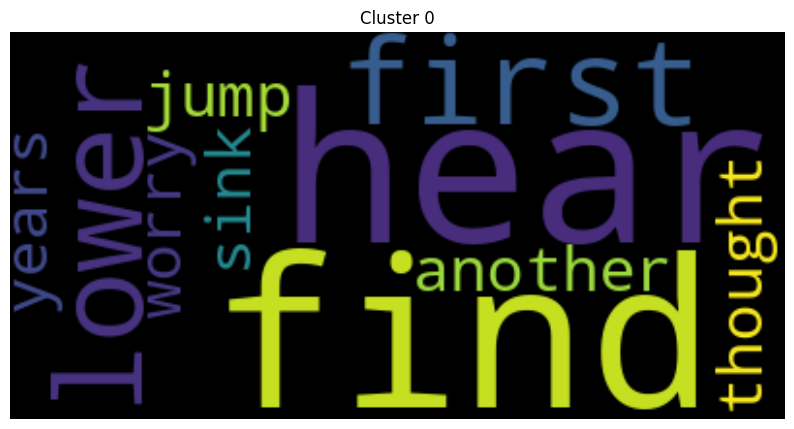

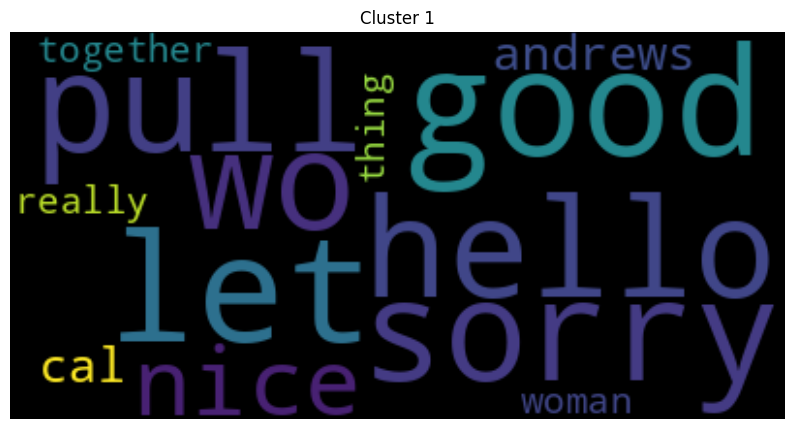

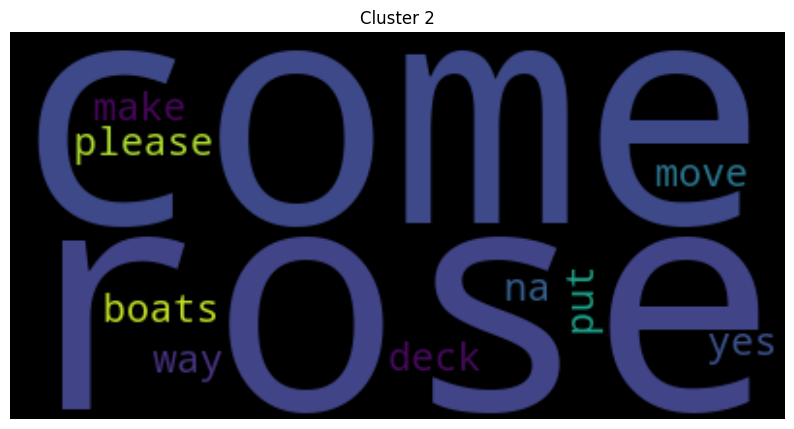

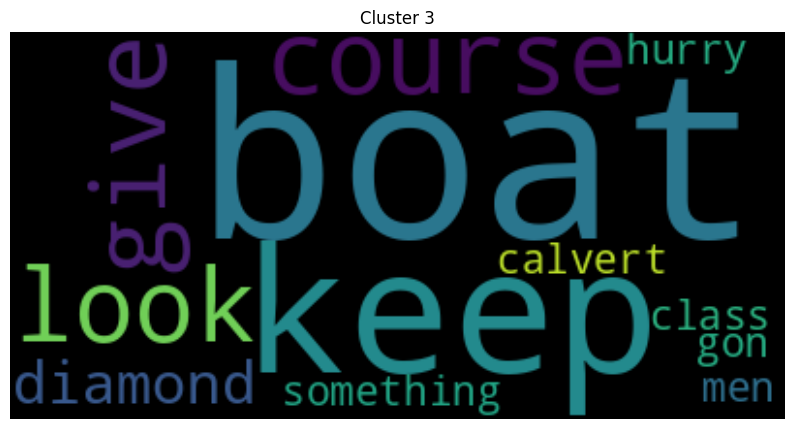

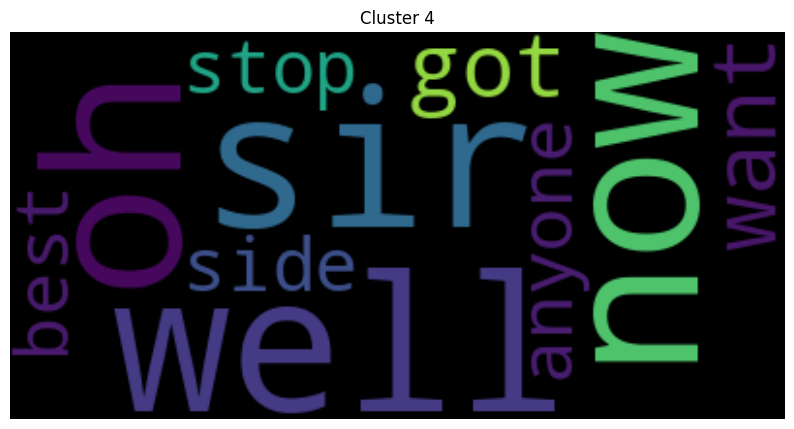

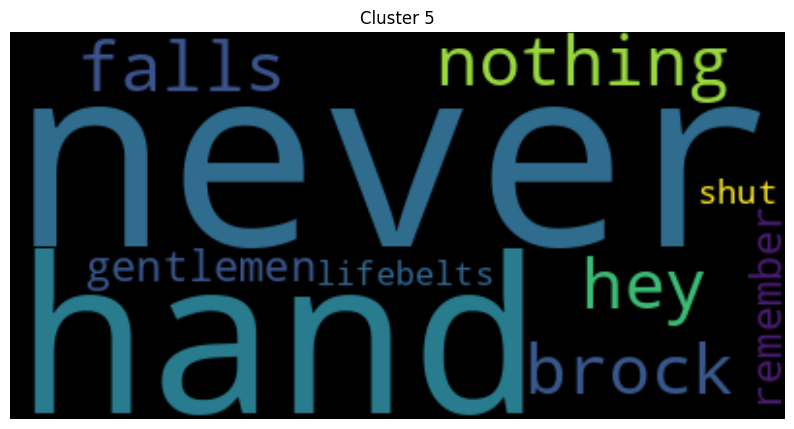

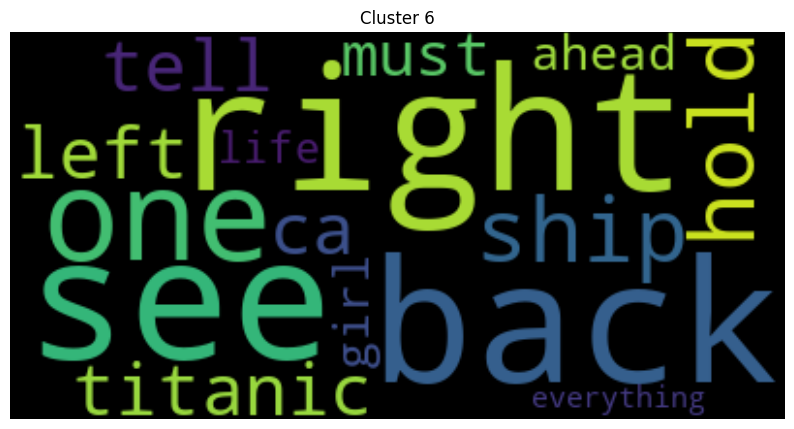

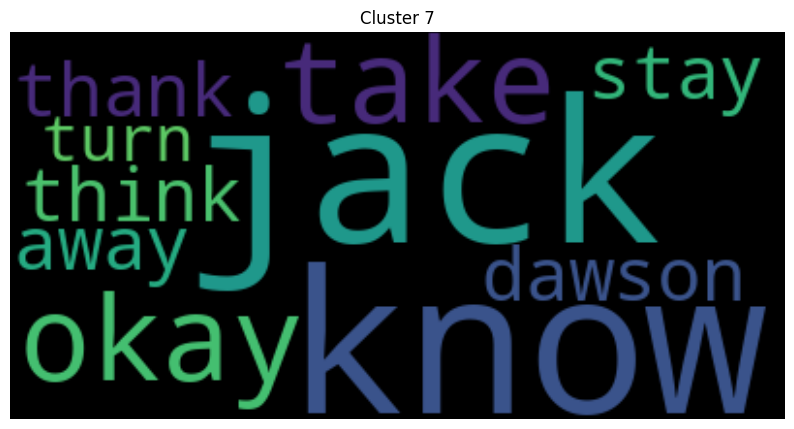

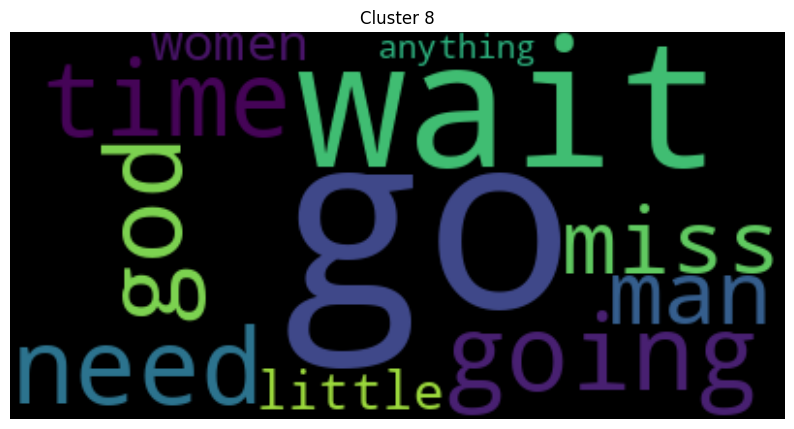

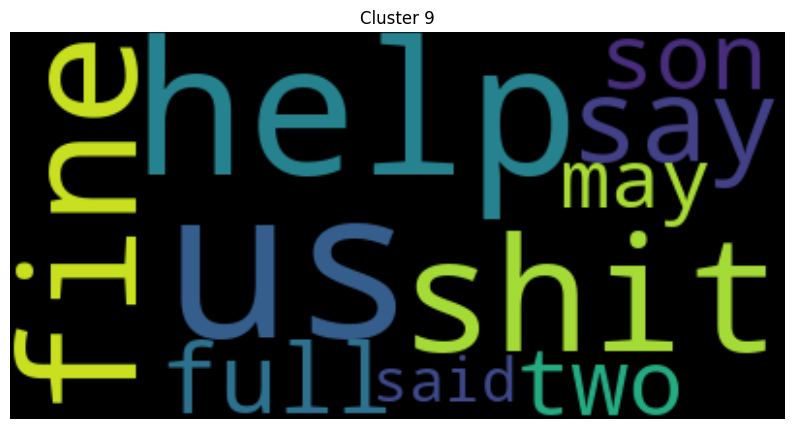

In [154]:
# Case V_100_K_10_seed_0
num_clusters = 10
cluster_labels = clustering(model, num_clusters)
clusters = get_top_words_per_cluster(num_clusters, cluster_labels, model)
visualize_clusters_wordcloud(clusters)

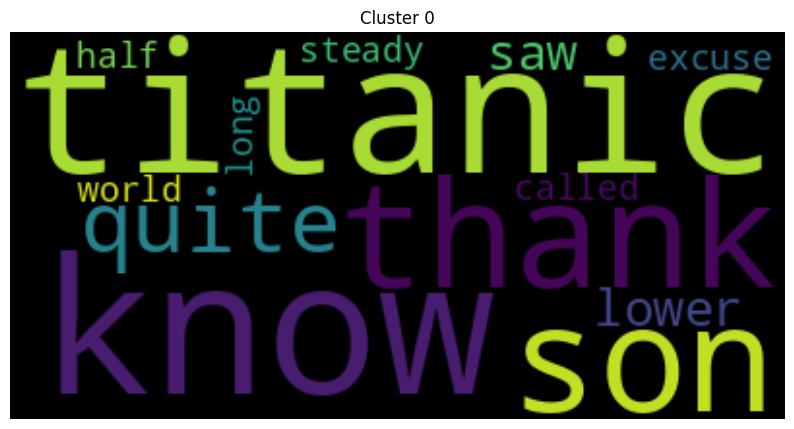

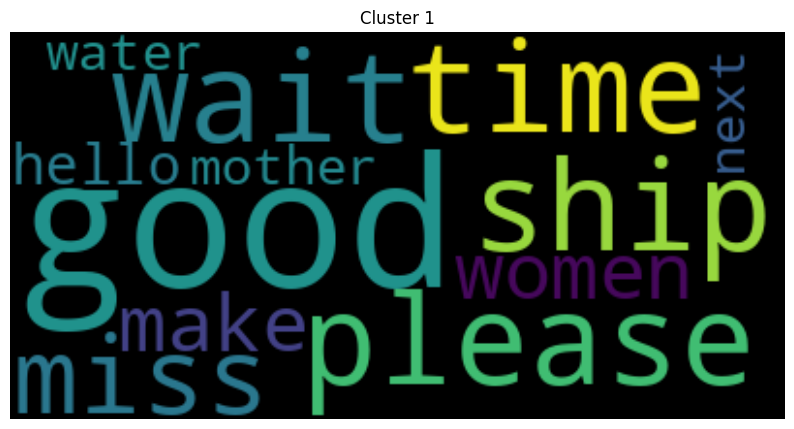

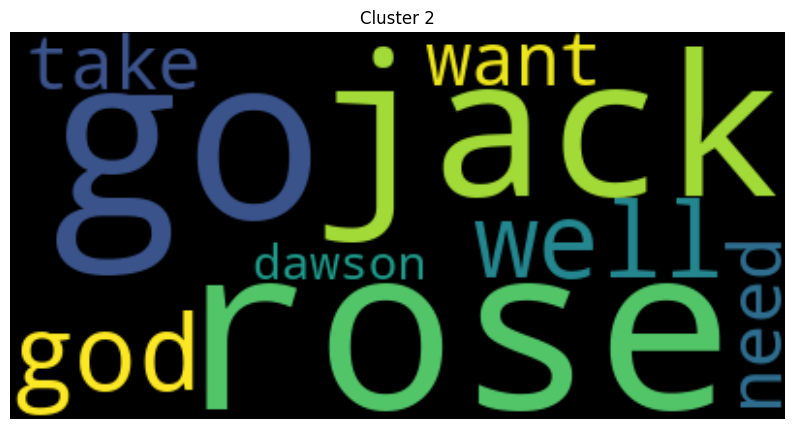

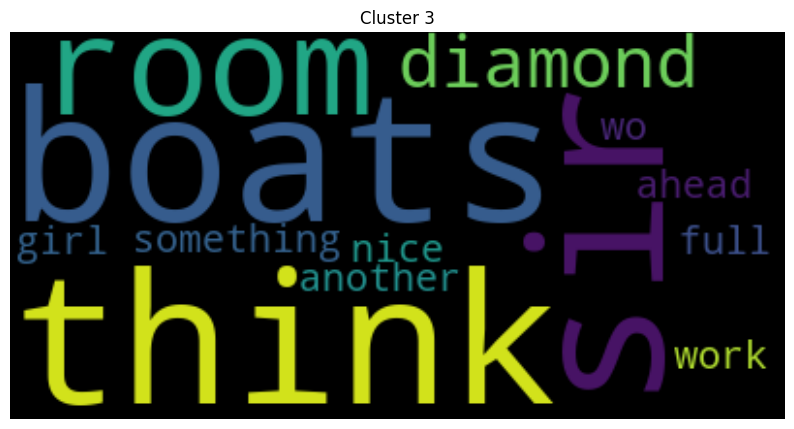

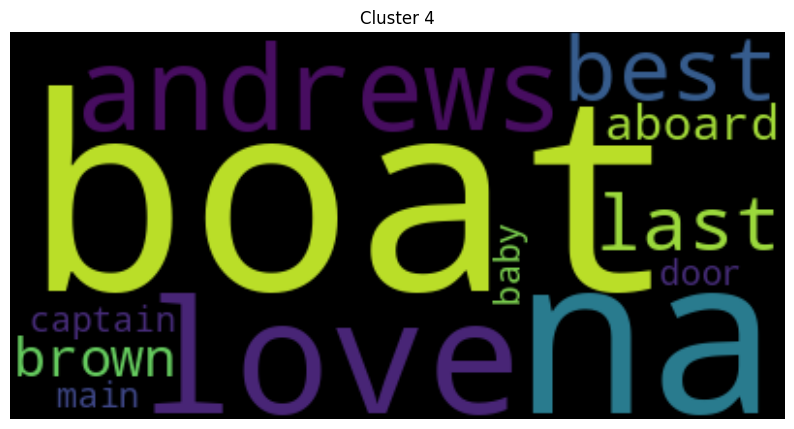

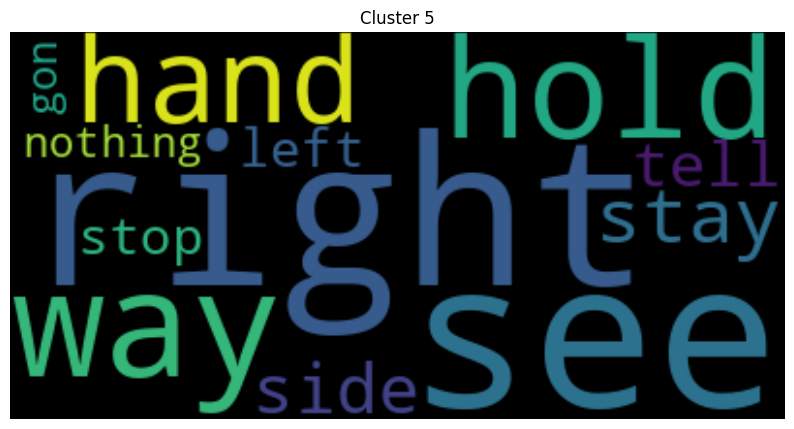

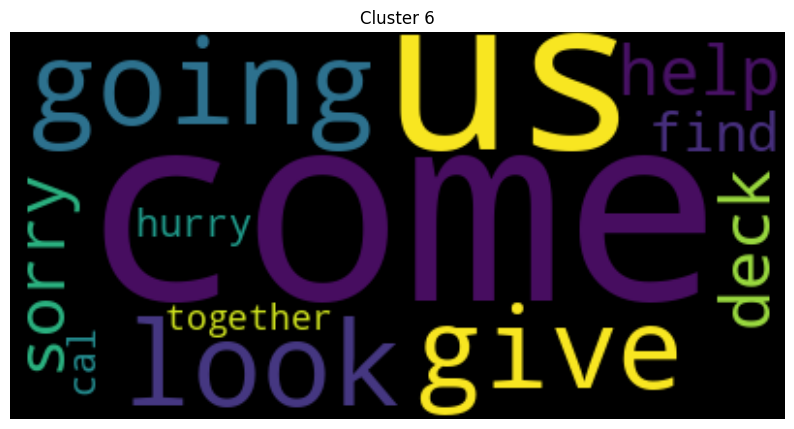

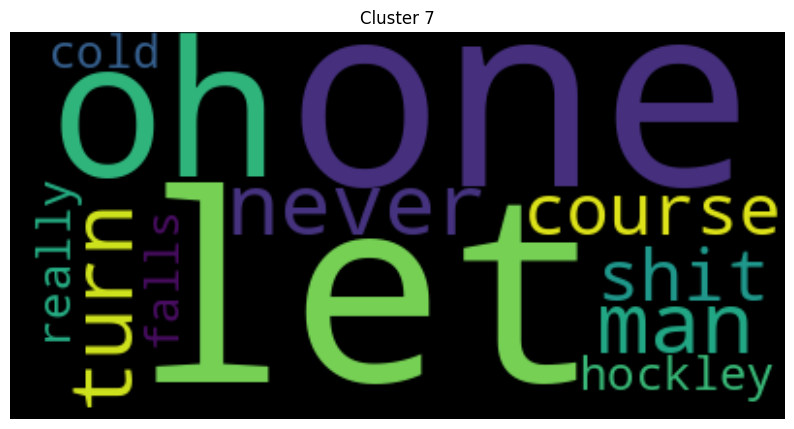

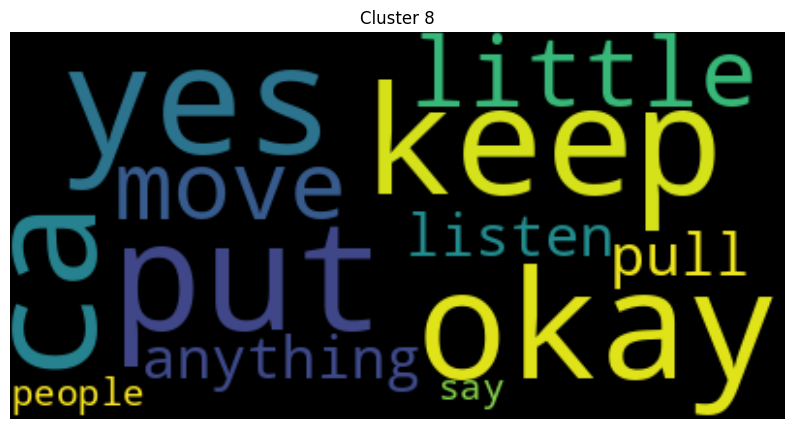

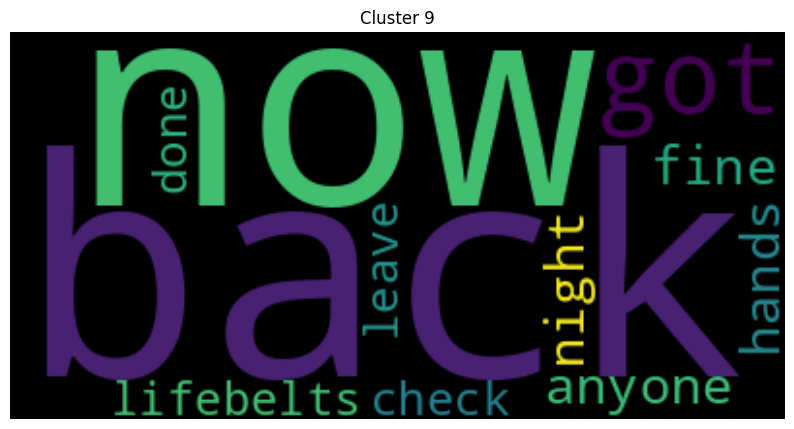

In [155]:
# Case V_100_K_10_seed_23
num_clusters = 10
cluster_labels = clustering(model, num_clusters, seed=23)
clusters = get_top_words_per_cluster(num_clusters, cluster_labels, model)
visualize_clusters_wordcloud(clusters)

## Conclusion:

* We first tried to understand what are word to vector embeddings.

* We saw what are the 2 ways for word2vec embedding:
    * **CBOW** and **Skip-Gram**

* CBOW (Continuous Bag of Words): Predicts a target word based on the surrounding context.

* Skip-gram: Predicts surrounding context words based on a target word.

* We read a subtitles file and preprocessed it, which converted our corpus to a list of lists of token.

* Preprocessing included removing punctuations, converting to lowercase, and removing stopwords. We saw in total we have:
    * 2608 total sentences
    * 7214 total words
    * 1861 unique words

* We comment that this is relatively small dataset for NLP tasks, and there are potential limitations:
    * The model's vocabulary coverage may be limited, especially for rarer words.
    * Overfitting might be possible

* Then we tried to apply the Word2Vec module from the `gensim` library.

* But we needed to first estimate `vector_size`, which we found out to be 70 (it turns out that this is a good value for our case, (1861 unique words))

* Then we tried to cluster them using k-means, and found out that k = 10 gives the best results.

* We tried to justify the clusters, and noticed that not all clusters are very clear, and some words are not very related to the cluster, but we can see some sense of similarity among the words in the cluster.

* The slightly poor results can be attributed to the fact that movies have in general small dialogues, low number of sentences, and hence the context is not very clear. Many ideas in movies are delivered through visual and audio cues, which are not present in the subtitles file.

* At the end we also saw wordclouds for all the clusters for 2 cases, providing a visual feel of clusters


## Future Work
* More analysis could have been possible if the character vs dialogue was present in a subtitles file. It could help us figure out if any character dominates any specific cluster providing **character specific attributes**.

* One could also try to plot clusters as the plot progresses, to notice how the clusters change throughout the film's runtime. This could help us to link clusters to specific stages of the movie moments.

## References:
https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

https://medium.com/@zafaralibagh6/simple-tutorial-on-word-embedding-and-word2vec-43d477624b6d

https://radimrehurek.com/gensim/models/word2vec.html

https://radimrehurek.com/gensim/models/keyedvectors.html